In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf

%pip install keras-tcn --no-dependencies

%pip install tensorflow-addons[tensorflow-gpu] --no-dependencies

%pip install pandas --upgrade

%pip install multivariate_cwru

%pip install tqdm

%pip install scipy

%pip install sklearn

%pip install matplotlib

%pip install typeguard


tf.config.list_physical_devices(device_type=None)
physical_devices = tf.config.list_physical_devices('GPU')
visible_devices = tf.config.get_visible_devices()
print(visible_devices)
num_GPU = len(tf.config.experimental.list_physical_devices('/physical_device:GPU:0'))
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

#Deep Learning pkgs
from tensorflow.keras import backend as K, Input, Model, optimizers
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.metrics
from tensorflow.keras.metrics import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.activations import swish
K.backend()

# Python
from IPython.core.debugger import set_trace
from pathlib import Path
import os
import datetime
import time
import glob
from timeit import default_timer as timer


#Project Specific
import tcn_ed
from tcn_ed import TCN, tcn_full_summary, compiled_tcn
from help_pre import create_data_batcht as Create_Batch, create_pred_batch
import multivariate_cwru

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You 

In [2]:
def csv_import(dir_p, use_type, high_freq = False, b_size=1024):
    segment_length = 2400
    target = 'label'
    cwd = os.getcwd()
    col_ran = [*range(2400)]
    d_t = dict()
    d_t['label'] = 'int8'
    d_t['Unnamed: 0'] = 'int8'
    for col in col_ran:
        d_t['%s' % col] =  'float16'
    
    if str(cwd) == str(dir_p):
        dir_path=Path('./')
    else: dir_path = dir_p
    
    if use_type == 'train':
        if high_freq == False:
            train_frame = pd.read_csv((r'{}.csv').format('train_df_no48'), dtype=(d_t))
            test_frame = pd.read_csv((r'{}.csv').format('test_df_no48'), dtype=(d_t))
            
        if high_freq:
            train_frame = pd.read_csv((r'{}.csv').format('train_df_w48'), dtype=(d_t))
            test_frame = pd.read_csv((r'{}.csv').format('test_df_w48'), dtype=(d_t))
            
        train_frame = train_frame.set_index(train_frame.iloc[:, 0]).drop('Unnamed: 0', axis=1)
        train_target = train_frame.pop('label')
        train_x = train_frame.to_numpy().reshape(len(train_frame), segment_length, 1)
        train_y = train_target.to_numpy().reshape(-1, 1)
        options = tf.data.Options()
        options.experimental_optimization.apply_default_optimizations = True
        train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(b_size).with_options(options).cache()
        test_frame = test_frame.set_index(test_frame.iloc[:, 0]).drop('Unnamed: 0', axis=1)
        test_target = test_frame.pop('label')
        test_x = test_frame.to_numpy().reshape(len(test_frame), segment_length, 1)
        test_y = test_target.to_numpy().reshape(-1, 1)
        test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(b_size).with_options(options).cache()
        print('class balance of train frame: %s' % train_target.value_counts())
        print('class balance of validation (test) frame: %s' % test_target.value_counts())
        out_1 = train_dataset
        out_2 = test_dataset
            
    if use_type == 'pred':
        if high_freq == False:
            val_frame = pd.read_csv((r'{}.csv').format('pred_df_no48'), dtype=d_t)
            
        if high_freq:
            val_frame == pd.read_csv((r'{}.csv').format('pred_df_w48'), dtype=d_t)


        val_frame = val_frame.set_index(val_frame.iloc[:, 0]).drop('Unnamed: 0', axis=1)

        val_target = val_frame.pop('label')
        print('class balance of train frame: %s' % val_target.value_counts())
        val_x = val_frame.to_numpy().reshape(len(val_frame), segment_length, 1)
        val_y = val_target.to_numpy().reshape(-1, 1)

        options = tf.data.Options()
        options.experimental_optimization.apply_default_optimizations = True
        dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(b_size).with_options(options).cache()

        out_1 = dataset
        out_2 = val_y
        
    return out_1, out_2

def adjust_dilations(dilations: list):
    if all([is_power_of_two(i) for i in dilations]):
        return dilations
    else:
        new_dilations = [2 ** i for i in dilations]
        return new_dilations
        
def pred_accuracy(y_true, y_pred):
            # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
            # convert dense predictions to labels
            y_pred_labels = K.cast(y_pred, K.floatx())
            return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

def create_model(num_feat,
                 num_classes,
                 filt_num,
                 kernel_num,
                 stack, dilation,
                 lr,
                 drop_rate,
                 segment_length,
                 use_skip,
                 opt):

    #with mirrored_strategy.scope():

    input_layer = Input(shape=(segment_length, num_feat))

    def get_opt():
        if opt == 'adam':
            return optimizers.Adam(lr=lr)
        elif opt == 'rmsprop':
            return optimizers.RMSprop(lr=lr)
        else:
            raise Exception('Only Adam and RMSProp are available here')

    x = TCN(nb_filters=filt_num,
            kernel_size=kernel_num,
            nb_stacks=stack,
            dilations=[2 ** i for i in range(dilation)],
            padding='causal',
            use_skip_connections=use_skip,
            dropout_rate=drop_rate,
            return_sequences=False,
            activation='swish', 
            kernel_initializer='he_uniform',
            use_batch_norm=False,
            use_layer_norm=False,
            use_weight_norm=True,
            name='Model')(input_layer)

    tcn = TCN(nb_filters=filt_num,
              kernel_size=kernel_num,
              nb_stacks=stack,
              dilations=[2 ** i for i in range(dilation)],
              padding='causal',
              use_skip_connections=use_skip,
              dropout_rate=drop_rate,
              return_sequences=False,
              activation='swish', 
              kernel_initializer='he_uniform',
              use_batch_norm=False,
              use_layer_norm=False,
              use_weight_norm=True,
              name='Model')

    print('Receptive Field Size: %s' % tcn.receptive_field)



    print('x.shape=', x.shape)


    # classification
    x = Dense(num_classes)(x)
    x = Activation('softmax', dtype='float32')(x)
    output_layer = x
    model = Model(input_layer, output_layer)

    # https://github.com/keras-team/keras/pull/11373
    # It's now in Keras@master but still not available with pip.
    # TODO remove later.

    #with mirrored_strategy.scope():
    model.compile(get_opt(), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

    print('model.x = {}'.format(input_layer.shape))
    print('model.y = {}'.format(output_layer.shape))

    print('Filter Length: %s' % filt_num)
    print('Kernel Size: %s' % kernel_num)
    print('Dilation: %s' % dilation)
    print('Learning Rate: %s' % lr)
    print('Dropout Rate: %s' % drop_rate)

    model.summary()


    return model

def train_func(train_data,
               test_dataset,
               Val_dataset,
               predict_labels,
               segment_length,
               runs,
               filt_num,
               kernel_num,
               dilation,
               stack,
               learn_r,
               drop_rate,
               Model_num,
               callback):
    
    
        
    time1 = timer()
        
    working_dir = Path('.')
    model_path = working_dir / 'Model' / ('Model_{}_k{}_s{}_di{}_dr{}_L{}'.format(Model_num, kernel_num, stack, dilation, drop_rate, segment_length))
    
    time_out = timer()-time1
    print('Time till start of create model %s' % time_out)
    time2 = timer()
    model = create_model(num_feat=1,
                         num_classes=4,
                         filt_num=filt_num,
                         kernel_num=kernel_num,
                         stack=stack,
                         dilation=dilation,
                         lr=learn_r,
                         drop_rate=drop_rate,
                         segment_length = segment_length,
                         use_skip=True,
                         opt='adam')

    time3 = timer()
    time_out = time3-time2
    print('Time to create model %s' % time_out)
    #with mirrored_strategy.scope():
    history = model.fit(train_data,
              epochs=runs,
              verbose=1,
              callbacks=callback,
              validation_data=test_dataset)
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.show()
    plt.plot(history.history['loss'])
    plt.show()
    time_out = timer()-time3
    print('Time to fit model %s' % time_out)
    #with mirrored_strategy.scope():
    y_preds = model.predict(Val_dataset,
                                   verbose=1,
                                   callbacks=callback,
                                  )
    y_argmax2 = np.argmax(y_preds,axis=1)
    predict_labels = np.squeeze(predict_labels[:], axis=1)
    #for pred1, pred2, pred3, pred4 in y_pred:
    #y_argmax = []
    #i=0
    perc_score = tf.dtypes.cast((sum(pred_accuracy(predict_labels, y_argmax2))/(len(predict_labels))), tf.float16)
    Accuracy_test = float(perc_score)
    print('Prediction Accuracy: %s' % Accuracy_test)
    con_mat = metrics.confusion_matrix(predict_labels, y_argmax2)
    class_report = metrics.classification_report(predict_labels, y_argmax2, digits=3)
    print(con_mat, '\n\n')
    print(class_report, '\n\n')
    
    

    
    d = {'segment length':[segment_length], 'filters': [filt_num], 'kernel size': [kernel_num], 'stacks':[stack], 'dropout': [drop_rate], 'lr': [learn_r], 'dilation': [dilation], 'Training Time': time_out, 'train loss': [history.history['loss'][-1]], 'train acc': [history.history['sparse_categorical_accuracy'][-1]], 'eval acc': [history.history['val_sparse_categorical_accuracy'][-1]], 'Eval Acc': [Accuracy_test],'C1 correct': [con_mat[0][0]], 'C1 as C2':[con_mat[0][1]], 'C1 as C3':[con_mat[0][2]], 'C1 as C4':[con_mat[0][3]],'C2 as C1': [con_mat[1][0]], 'C2 correct':[con_mat[1][1]], 'C2 as C3':[con_mat[1][2]], 'C2 as C4':[con_mat[1][3]],'C3 as C1': [con_mat[2][0]], 'C3 as C2':[con_mat[2][1]], 'C3 correct':[con_mat[2][2]], 'C3 as C4':[con_mat[2][3]],'C4 as C1': [con_mat[3][0]], 'C4 as C2':[con_mat[3][1]], 'C4 as C3':[con_mat[3][2]], 'C4 correct':[con_mat[3][3]]}
    
    
    append_list2_in = pd.DataFrame.from_dict(d)
    
    time_out = timer()-time1
    print('Total Time %s' % time_out)
    
    return model, history, y_preds, append_list2_in

def create_model2(num_feat,
                 num_classes,
                 filt_num,
                 kernel_num,
                 stack, dilation,
                 lr,
                 drop_rate,
                 segment_length,
                 use_skip,
                 opt):




    #with mirrored_strategy.scope():
    #x =Sequential()


    input_layer = Input(shape=(segment_length, num_feat))

    def get_opt():
        if opt == 'adam':
            return optimizers.Adam(lr=lr)
        elif opt == 'rmsprop':
            return optimizers.RMSprop(lr=lr)
        else:
            raise Exception('Only Adam and RMSProp are available here')

    x = TCN(nb_filters=filt_num,
            kernel_size=kernel_num,
            nb_stacks=stack,
            dilations=[2 ** i for i in range(dilation)],
            padding='causal',
            use_skip_connections=use_skip,
            dropout_rate=drop_rate,
            return_sequences=False,
            activation='swish', 
            kernel_initializer='he_uniform',
            use_batch_norm=True,
            use_layer_norm=False,
            use_weight_norm=False,
            name='Model')(input_layer)

    tcn = TCN(nb_filters=filt_num,
              kernel_size=kernel_num,
              nb_stacks=stack,
              dilations=[2 ** i for i in range(dilation)],
              padding='causal',
              use_skip_connections=use_skip,
              dropout_rate=drop_rate,
              return_sequences=False,
              activation='swish', 
              kernel_initializer='he_uniform',
              use_batch_norm=True,
              use_layer_norm=False,
              use_weight_norm=False,
              name='Model')

    print('Receptive Field Size: %s' % tcn.receptive_field)



    print('x.shape=', x.shape)


    # classification
    x = Dense(num_classes)(x)
    x = Activation('softmax', dtype='float32')(x)
    output_layer = x
    model = Model(input_layer, output_layer)

    # https://github.com/keras-team/keras/pull/11373
    # It's now in Keras@master but still not available with pip.
    # TODO remove later.

    #with mirrored_strategy.scope():
    model.compile(get_opt(), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

    print('model.x = {}'.format(input_layer.shape))
    print('model.y = {}'.format(output_layer.shape))

    print('Filter Length: %s' % filt_num)
    print('Kernel Size: %s' % kernel_num)
    print('Dilation: %s' % dilation)
    print('Learning Rate: %s' % lr)
    print('Dropout Rate: %s' % drop_rate)

    model.summary()


    return model

def train_func2(train_data,
               test_dataset,
               Val_dataset,
               predict_labels,
               segment_length,
               runs,
               filt_num,
               kernel_num,
               dilation,
               stack,
               learn_r,
               drop_rate,
               Model_num,
               callback):
    
    
        
    time1 = timer()
        
    working_dir = Path('.')
    model_path = working_dir / 'Model' / ('Model_{}_k{}_s{}_di{}_dr{}_L{}.H5'.format(Model_num, kernel_num, stack, dilation, drop_rate, segment_length))
    
    

    #seg_length = None
    time_out = timer()-time1
    print('Time till start of create model %s' % time_out)
    time2 = timer()
    model = create_model2(num_feat=1,
                         num_classes=4,
                         filt_num=filt_num,
                         kernel_num=kernel_num,
                         stack=stack,
                         dilation=dilation,
                         lr=learn_r,
                         drop_rate=drop_rate,
                         segment_length = segment_length,
                         use_skip=True,
                         opt='adam')

    time3 = timer()
    time_out = time3-time2
    print('Time to create model %s' % time_out)
    #with mirrored_strategy.scope():
    history = model.fit(train_data,
              epochs=runs,
              verbose=1,
              callbacks=callback,
              validation_data=test_dataset,
              use_multiprocessing=True)
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.show()
    plt.plot(history.history['loss'])
    plt.show()
    time_out = timer()-time3
    print('Time to fit model %s' % time_out)
    #with mirrored_strategy.scope():
    y_preds = model.predict(Val_dataset,
                                   verbose=1,
                                   callbacks=callback,
                                  )
    y_argmax2 = np.argmax(y_preds,axis=1)
    predict_labels = np.squeeze(predict_labels[:], axis=1)
    #for pred1, pred2, pred3, pred4 in y_pred:
    #y_argmax = []
    #i=0
    perc_score = tf.dtypes.cast((sum(pred_accuracy(predict_labels, y_argmax2))/(len(predict_labels))), tf.float16)
    Accuracy_test = float(perc_score)
    print('Prediction Accuracy: %s' % Accuracy_test)
    con_mat = metrics.confusion_matrix(predict_labels, y_argmax2)
    class_report = metrics.classification_report(predict_labels, y_argmax2, digits=3)
    print(con_mat, '\n\n')
    print(class_report, '\n\n')
    
    

    
    d = {'segment length':[segment_length], 'filters': [filt_num], 'kernel size': [kernel_num], 'stacks':[stack], 'dropout': [drop_rate], 'lr': [learn_r], 'dilation': [dilation], 'Training Time': time_out, 'train loss': [history.history['loss'][-1]], 'train acc': [history.history['sparse_categorical_accuracy'][-1]], 'eval acc': [history.history['val_sparse_categorical_accuracy'][-1]], 'Eval Acc': [Accuracy_test],'C1 correct': [con_mat[0][0]], 'C1 as C2':[con_mat[0][1]], 'C1 as C3':[con_mat[0][2]], 'C1 as C4':[con_mat[0][3]],'C2 as C1': [con_mat[1][0]], 'C2 correct':[con_mat[1][1]], 'C2 as C3':[con_mat[1][2]], 'C2 as C4':[con_mat[1][3]],'C3 as C1': [con_mat[2][0]], 'C3 as C2':[con_mat[2][1]], 'C3 correct':[con_mat[2][2]], 'C3 as C4':[con_mat[2][3]],'C4 as C1': [con_mat[3][0]], 'C4 as C2':[con_mat[3][1]], 'C4 as C3':[con_mat[3][2]], 'C4 correct':[con_mat[3][3]]}
    
    
    append_list2_in = pd.DataFrame.from_dict(d)
       
    time_out = timer()-time1
    print('Total Time %s' % time_out)
    
    return model, history, y_preds, append_list2_in

In [3]:
col_ran = [*range(2400)]

In [4]:
train_dataset, test_dataset = csv_import(dir_p = os.getcwd(), use_type='train', high_freq = True)

class balance of train frame: 3    57451
1    28917
2    28747
0     9656
Name: label, dtype: int64
class balance of validation (test) frame: 3    30229
1    12081
2    11013
0     9650
Name: label, dtype: int64


In [5]:
val_dataset, predict_labels = csv_import(dir_p = os.getcwd(), use_type = 'pred' , high_freq = False)

class balance of train frame: 3    4770
1    2384
2    2384
0    1612
Name: label, dtype: int64


In [6]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5,   
                              patience=3, 
                              min_lr=0.000000015,
                              verbose=1, 
                              cooldown=5)

ES_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                         min_delta=0.00001, 
                                         patience=25, 
                                         verbose=0, 
                                         mode='auto', 
                                         baseline=None, 
                                         restore_best_weights=True)



callback = [reduce_lr, ES_cb]

In [7]:
b_size = 1024 #normally 2048 but 512 on colab
step_size = 300
step_length=step_size
segment_length = 2400
split_perc = 0.3
working_dir = Path('.')
DATA_PATH = Path("./Datatest/CWRU")
save_model_path = working_dir / 'Model' 

for path in [DATA_PATH, save_model_path]:
    if not path.exists():
        path.mkdir(parents=True)

In [ ]:
append_list_time1=pd.DataFrame()
Learning_Rate = 0.02
Drop_rate = 0
Repeats = 75
m_count=1
print('Model Number %s' % m_count)
model1, history1, y_preds, res_list = train_func2(train_data=train_dataset,
                                        test_dataset=test_dataset,
                                        Val_dataset=val_dataset,
                                        predict_labels=predict_labels, 
                                        filt_num=4,
                                        kernel_num=8,
                                        dilation=7,
                                        stack=1,
                                        learn_r=Learning_Rate,
                                        drop_rate=Drop_rate,
                                        runs=Repeats,
                                        Model_num = m_count, 
                                        segment_length = segment_length,
                                        callback = callback)

append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
tf.keras.backend.clear_session()

In [8]:
import os
segment_length = 2400
target = 'label'
cwd = os.getcwd()
col_ran = [*range(2400)]
b_size = 512
d_t = dict()
d_t['label'] = 'int8'
d_t['Unnamed: 0'] = 'int8'
for col in col_ran:
    d_t['%s' % col] =  'float32'



train_frame = pd.read_csv((r'{}.csv').format('train_df_w48'), dtype=(d_t))
test_frame = pd.read_csv((r'{}.csv').format('test_df_w48'), dtype=(d_t))

train_frame = train_frame.set_index(train_frame.iloc[:, 0]).drop('Unnamed: 0', axis=1)
train_target = train_frame.pop('label')
train_x = train_frame.to_numpy().reshape(len(train_frame), segment_length, 1)
train_y = train_target.to_numpy().reshape(-1, 1)
options = tf.data.Options()
options.experimental_optimization.apply_default_optimizations = True
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(b_size).with_options(options).cache()
test_frame = test_frame.set_index(test_frame.iloc[:, 0]).drop('Unnamed: 0', axis=1)
test_target = test_frame.pop('label')
test_x = test_frame.to_numpy().reshape(len(test_frame), segment_length, 1)
test_y = test_target.to_numpy().reshape(-1, 1)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(b_size).with_options(options).cache()
print('class balance of train frame: %s' % train_target.value_counts())
print('class balance of validation (test) frame: %s' % test_target.value_counts())
out_1 = train_dataset
out_2 = test_dataset

val_frame = pd.read_csv((r'{}.csv').format('pred_df_no48'), dtype=d_t)


val_frame = val_frame.set_index(val_frame.iloc[:, 0]).drop('Unnamed: 0', axis=1)

val_target = val_frame.pop('label')
print('class balance of train frame: %s' % val_target.value_counts())
val_x = val_frame.to_numpy().reshape(len(val_frame), segment_length, 1)
val_y = val_target.to_numpy().reshape(-1, 1)

options = tf.data.Options()
options.experimental_optimization.apply_default_optimizations = True
dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(b_size).with_options(options).cache()

val_dataset = dataset
out_2 = val_y

class balance of train frame: 3    57451
1    28917
2    28747
0     9656
Name: label, dtype: int64
class balance of validation (test) frame: 3    30229
1    12081
2    11013
0     9650
Name: label, dtype: int64
class balance of train frame: 3    4770
2    2384
1    2384
0    1612
Name: label, dtype: int64


In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.3,   
                              patience=10, 
                              min_lr=0.0000000015,
                              verbose=0, 
                              cooldown=5)

ES_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                         min_delta=0.00001, 
                                         patience=25, 
                                         verbose=0, 
                                         mode='auto', 
                                         baseline=None, 
                                         restore_best_weights=True)



callback = [reduce_lr, ES_cb]

Model Number 1
Time till start of create model 4.165699647273868e-05
[2021-05-12 05:44:21.076 tensorflow-2-3-gpu-ml-g4dn-4xlarge-f1d995902f6ec07d1f4d0a5fa443:4722 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-05-12 05:44:21.100 tensorflow-2-3-gpu-ml-g4dn-4xlarge-f1d995902f6ec07d1f4d0a5fa443:4722 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Receptive Field Size: 2541
x.shape= (None, 8)
model.x = (None, 2400, 1)
model.y = (None, 4)
Filter Length: 8
Kernel Size: 11
Dilation: 7
Learning Rate: 0.02
Dropout Rate: 0
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2400, 1)]         0         
_________________________________________________________________
Model (TCN)                  (None, 8)                 9816      
_______________________________________

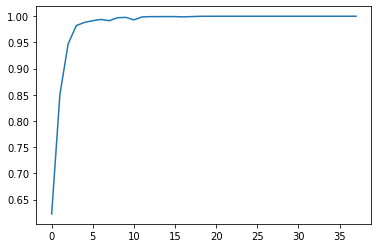

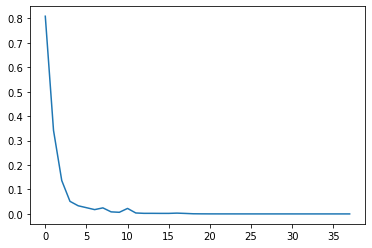

Time to fit model 3992.4630388369987
 2/11 [====>.........................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0118s vs `on_predict_batch_end` time: 0.1980s). Check your callbacks.


11/11 [==============================] - 2s 208ms/step
Prediction Accuracy: 0.9111328125
[[1612    0    0    0]
 [   0 2281    3  100]
 [   0   68 2262   54]
 [   0  687   81 4002]] 


              precision    recall  f1-score   support

           0      1.000     1.000     1.000      1612
           1      0.751     0.957     0.842      2384
           2      0.964     0.949     0.956      2384
           3      0.963     0.839     0.897      4770

    accuracy                          0.911     11150
   macro avg      0.920     0.936     0.924     11150
weighted avg      0.923     0.911     0.913     11150
 


Total Time 3998.419894826002
Model Number 2


NameError: name 'val_y' is not defined

In [9]:
append_list_time1=pd.DataFrame()
Learning_Rate = 0.02
Drop_rate = 0
Repeats = 75
m_count=0
tf.keras.backend.clear_session()
Drop_rate=0
m_count += 1
print('Model Number %s' % m_count)
model2, history2, y_preds, res_list = train_func2(train_data=train_dataset,
                                        test_dataset=test_dataset,
                                        Val_dataset=val_dataset,
                                        predict_labels=predict_labels, 
                                        filt_num=8,
                                        kernel_num=11,
                                        dilation=7,
                                        stack=1,
                                        learn_r=Learning_Rate,
                                        drop_rate=Drop_rate,
                                        runs=Repeats,
                                        Model_num = m_count, 
                                        segment_length = segment_length,
                                        callback = callback)

append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
tf.keras.backend.clear_session()

Drop_rate=0.1
m_count += 1
print('Model Number %s' % m_count)
model2, history2, y_preds, res_list = train_func2(train_data=train_dataset,
                                        test_dataset=test_dataset,
                                        Val_dataset=val_dataset,
                                        predict_labels=predict_labels, 
                                        filt_num=8,
                                        kernel_num=11,
                                        dilation=7,
                                        stack=1,
                                        learn_r=Learning_Rate,
                                        drop_rate=Drop_rate,
                                        runs=Repeats,
                                        Model_num = m_count, 
                                        segment_length = segment_length,
                                        callback = callback)

append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
tf.keras.backend.clear_session()

In [ ]:
segment_length = 8192
target = 'label'
cwd = os.getcwd()
col_ran = [*range(8192)]
d_t = dict()
d_t['label'] = 'int8'
d_t['Unnamed: 0'] = 'int8'
for col in col_ran:
    d_t['%s' % col] =  'float16'



train_frame = pd.read_csv((r'{}.csv').format('train_df_w48_8192'), dtype=(d_t))
test_frame = pd.read_csv((r'{}.csv').format('test_df_w48_8192'), dtype=(d_t))

train_frame = train_frame.set_index(train_frame.iloc[:, 0]).drop('Unnamed: 0', axis=1)
train_target = train_frame.pop('label')
train_x = train_frame.to_numpy().reshape(len(train_frame), segment_length, 1)
train_y = train_target.to_numpy().reshape(-1, 1)
options = tf.data.Options()
options.experimental_optimization.apply_default_optimizations = True
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(b_size).with_options(options).cache()
test_frame = test_frame.set_index(test_frame.iloc[:, 0]).drop('Unnamed: 0', axis=1)
test_target = test_frame.pop('label')
test_x = test_frame.to_numpy().reshape(len(test_frame), segment_length, 1)
test_y = test_target.to_numpy().reshape(-1, 1)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(b_size).with_options(options).cache()
print('class balance of train frame: %s' % train_target.value_counts())
print('class balance of validation (test) frame: %s' % test_target.value_counts())
out_1 = train_dataset
out_2 = test_dataset

val_frame = pd.read_csv((r'{}.csv').format('pred_df_no48_8192'), dtype=d_t)


val_frame = val_frame.set_index(val_frame.iloc[:, 0]).drop('Unnamed: 0', axis=1)

val_target = val_frame.pop('label')
print('class balance of train frame: %s' % val_target.value_counts())
val_x = val_frame.to_numpy().reshape(len(val_frame), segment_length, 1)
val_y = val_target.to_numpy().reshape(-1, 1)

options = tf.data.Options()
options.experimental_optimization.apply_default_optimizations = True
dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(b_size).with_options(options).cache()

val_dataset = dataset
predict_labels = val_y

In [ ]:

tf.keras.backend.clear_session()
Drop_rate=0
m_count += 1
print('Model Number %s' % m_count)
model1, history1, y_preds, res_list = train_func2(train_data=train_dataset,
                                        test_dataset=test_dataset,
                                        Val_dataset=val_dataset,
                                        predict_labels=predict_labels, 
                                        filt_num=8,
                                        kernel_num=11,
                                        dilation=7,
                                        stack=1,
                                        learn_r=Learning_Rate,
                                        drop_rate=Drop_rate,
                                        runs=Repeats,
                                        Model_num = m_count, 
                                        segment_length = segment_length,
                                        callback = callback)

append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
tf.keras.backend.clear_session()

tf.keras.backend.clear_session()
Drop_rate=0.1
m_count += 1
print('Model Number %s' % m_count)
model1, history1, y_preds, res_list = train_func2(train_data=train_dataset,
                                        test_dataset=test_dataset,
                                        Val_dataset=val_dataset,
                                        predict_labels=predict_labels, 
                                        filt_num=8,
                                        kernel_num=11,
                                        dilation=7,
                                        stack=1,
                                        learn_r=Learning_Rate,
                                        drop_rate=Drop_rate,
                                        runs=Repeats,
                                        Model_num = m_count, 
                                        segment_length = segment_length,
                                        callback = callback)

append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
tf.keras.backend.clear_session()

In [ ]:
segment_length = 8192
target = 'label'
cwd = os.getcwd()
col_ran = [*range(8192)]
d_t = dict()
d_t['label'] = 'float32'
d_t['Unnamed: 0'] = 'float32'
for col in col_ran:
    d_t['%s' % col] =  'float32'



train_frame = pd.read_csv((r'{}.csv').format('train_df_w48_8192'), dtype=(d_t))
test_frame = pd.read_csv((r'{}.csv').format('test_df_w48_8192'), dtype=(d_t))

train_frame = train_frame.set_index(train_frame.iloc[:, 0]).drop('Unnamed: 0', axis=1)
train_target = train_frame.pop('label')
train_x = train_frame.to_numpy().reshape(len(train_frame), segment_length, 1)
train_y = train_target.to_numpy().reshape(-1, 1)
options = tf.data.Options()
options.experimental_optimization.apply_default_optimizations = True
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(b_size).with_options(options).cache()
test_frame = test_frame.set_index(test_frame.iloc[:, 0]).drop('Unnamed: 0', axis=1)
test_target = test_frame.pop('label')
test_x = test_frame.to_numpy().reshape(len(test_frame), segment_length, 1)
test_y = test_target.to_numpy().reshape(-1, 1)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(b_size).with_options(options).cache()
print('class balance of train frame: %s' % train_target.value_counts())
print('class balance of validation (test) frame: %s' % test_target.value_counts())
out_1 = train_dataset
out_2 = test_dataset

val_frame = pd.read_csv((r'{}.csv').format('pred_df_no48_8192'), dtype=d_t)


val_frame = val_frame.set_index(val_frame.iloc[:, 0]).drop('Unnamed: 0', axis=1)

val_target = val_frame.pop('label')
print('class balance of train frame: %s' % val_target.value_counts())
val_x = val_frame.to_numpy().reshape(len(val_frame), segment_length, 1)
val_y = val_target.to_numpy().reshape(-1, 1)

options = tf.data.Options()
options.experimental_optimization.apply_default_optimizations = True
dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(b_size).with_options(options).cache()

val_dataset = dataset
out_2 = val_y

In [ ]:

tf.keras.backend.clear_session()
Drop_rate=0
m_count += 1
print('Model Number %s' % m_count)
model1, history1, y_preds, res_list = train_func2(train_data=train_dataset,
                                        test_dataset=test_dataset,
                                        Val_dataset=val_dataset,
                                        predict_labels=predict_labels, 
                                        filt_num=8,
                                        kernel_num=11,
                                        dilation=7,
                                        stack=1,
                                        learn_r=Learning_Rate,
                                        drop_rate=Drop_rate,
                                        runs=Repeats,
                                        Model_num = m_count, 
                                        segment_length = segment_length,
                                        callback = callback)

append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
tf.keras.backend.clear_session()

tf.keras.backend.clear_session()
Drop_rate=0.1
m_count += 1
print('Model Number %s' % m_count)
model1, history1, y_preds, res_list = train_func2(train_data=train_dataset,
                                        test_dataset=test_dataset,
                                        Val_dataset=val_dataset,
                                        predict_labels=predict_labels, 
                                        filt_num=8,
                                        kernel_num=11,
                                        dilation=7,
                                        stack=1,
                                        learn_r=Learning_Rate,
                                        drop_rate=Drop_rate,
                                        runs=Repeats,
                                        Model_num = m_count, 
                                        segment_length = segment_length,
                                        callback = callback)

append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
tf.keras.backend.clear_session()